# Get the vibe - Experimental Notebook

## Set up

### Imports

In [46]:
# General libraries
import numpy as np
import pandas as pd

# Image related
import matplotlib.pyplot as plt 
from matplotlib import image
from keras.preprocessing.image import load_img, img_to_array
import os

# CNN
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping

#### Set up

In [47]:
# Import Data 
image_df = pd.read_csv("../getthevibe_api/data/fer2013.csv")

In [48]:
# Data Path
# folder_path = "../../JaildoR/getthevibe_api/getthevibe_api/data/fer2013.csv"

In [49]:
# Define Emotions
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]  # indices 0 to 6

In [50]:
# Insert column emotions
image_df["emotion_new"] = image_df["emotion"].map({0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"})

### Display Images

In [51]:
# Define formate
FER2013_WIDTH = 48
FER2013_HEIGHT = 48

In [57]:
# Function showing picture
def show_image(index):
    """Shows the image and the emotion label of the index's instance."""
    image = image_df.at[index, "pixels"].split(" ")
    image = np.reshape(image,(FER2013_WIDTH, FER2013_HEIGHT)).astype("float")
    print(Emotions[image_df.at[index, "emotion"]])
    plt.imshow(image)

Angry


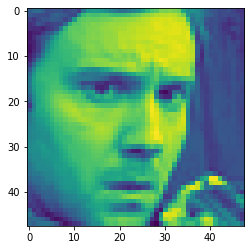

In [58]:
show_image(0)

###  Simple Descriptives

In [9]:
image_df.describe

<bound method NDFrame.describe of        emotion                                             pixels  \
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...   
1            0  151 150 147 155 148 133 111 140 170 174 182 15...   
2            2  231 212 156 164 174 138 161 173 182 200 106 38...   
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...   
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...   
...        ...                                                ...   
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...   
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...   
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...   
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...   
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...   

             Usage emotion_new  
0         Training       Angry  
1         Training       Angry  
2         Training        Fear  
3    

In [10]:
# Shape
image_df.shape

(35887, 4)

In [11]:
# Pixels per picture
exp_pixel = image_df.iloc[0]['pixels']
len(exp_pixel.split())

2304

In [12]:
# Format 
2304**0.5

48.0

In [13]:
# Check zeros
image_df.isnull().sum()

emotion        0
pixels         0
Usage          0
emotion_new    0
dtype: int64

### Advances Descriptives

#### Categories 

In [14]:
# Show emotional categories
cat_data = image_df["emotion"].value_counts().sort_index()
cat_data

0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
Name: emotion, dtype: int64

In [15]:
cat_data = image_df["emotion_new"].count()
cat_data

35887

<BarContainer object of 35887 artists>

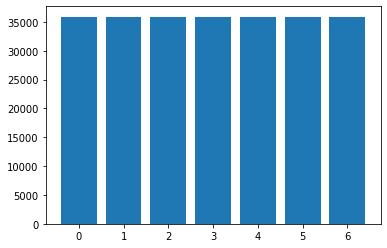

In [16]:
# Graph categories
x_axis = image_df["emotion"]
y_axis = cat_data
plt.bar(x_axis, y_axis)

## Preprosessing

### Training Data Split

In [17]:
train_set = image_df[(image_df.Usage == 'Training')] 
val_set = image_df[(image_df.Usage == 'PublicTest')]
test_set = image_df[(image_df.Usage == 'PrivateTest')] 

### Reshape X

In [18]:
# define x
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32) 
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 


X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

### One hot encode y

In [19]:
# define y
y_train = train_set["emotion"]
y_val = val_set["emotion"]
y_test = test_set["emotion"]

In [20]:
# One Hot Encode our Target for TensorFlow processing

y_cat_train = to_categorical(y_train, num_classes=7)
y_cat_test = to_categorical(y_test, num_classes=7)
y_cat_val = to_categorical(y_val, num_classes=7)

## Model

#### Notes on CNN

Notes on CNN: 
- the kernel size decreases
- the number of filters increases (compared to the previous layers)

- channels = depth of an image
- filters = operation on an image
    - has many kernels
    - with padding
    - with strides
- pooling layers reduces image size

### Stupid Model

#### Stupid Model Application

In [21]:
### 1. Architecture
model_st = models.Sequential()

model_st.add(layers.Conv2D(filters = 4, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model_st.add(layers.Conv2D(6, kernel_size=(2,2), activation='relu')) 

model_st.add(layers.Flatten())
model_st.add(layers.Dense(7, activation='softmax')) 

model_st.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 4)         40        
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 6)         102       
                                                                 
 flatten (Flatten)           (None, 12150)             0         
                                                                 
 dense (Dense)               (None, 7)                 85057     
                                                                 
Total params: 85,199
Trainable params: 85,199
Non-trainable params: 0
_________________________________________________________________


2022-03-03 13:02:12.350503: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
#### 2. Compilation
model_st.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
#### 3. Fit
es = EarlyStopping(patience=5)

history_st = model_st.fit(X_train, y_cat_train,
                    epochs=30,
                    batch_size=32, 
                    verbose=1,
                    validation_split=0.3,
                    callbacks=[es]) 

Epoch 1/30
628/628 [==============================] - 11s 18ms/step - loss: 1.8096 - accuracy: 0.3749 - val_loss: 1.8673 - val_accuracy: 0.3294
Epoch 2/30
628/628 [==============================] - 11s 18ms/step - loss: 1.4332 - accuracy: 0.4737 - val_loss: 1.9025 - val_accuracy: 0.3458
Epoch 3/30
628/628 [==============================] - 13s 20ms/step - loss: 1.2365 - accuracy: 0.5405 - val_loss: 1.9978 - val_accuracy: 0.3549
Epoch 4/30
628/628 [==============================] - 11s 18ms/step - loss: 1.1055 - accuracy: 0.5911 - val_loss: 2.0111 - val_accuracy: 0.3579
Epoch 5/30
628/628 [==============================] - 11s 18ms/step - loss: 1.0047 - accuracy: 0.6284 - val_loss: 2.1830 - val_accuracy: 0.3780
Epoch 6/30
628/628 [==============================] - 11s 18ms/step - loss: 0.9268 - accuracy: 0.6604 - val_loss: 2.2912 - val_accuracy: 0.3620


#### Stupid Model Evaluation

In [25]:
np.array(history_st.history["val_accuracy"])

array([0.32938582, 0.34575641, 0.35492858, 0.35794729, 0.37803319,
       0.36201093])

In [26]:
# Evaluate model on the test data
print(model_st.evaluate(X_test, y_cat_test, verbose=0))

[2.350912570953369, 0.36361104249954224]


In [40]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    
    ax1.set_ylim((0,3))
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_title('loss')
    ax1.legend()

    ax2.set_ylim((0,1))
    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_title('Accurary')
    ax2.legend()
    return (ax1, ax2)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accurary'}>)

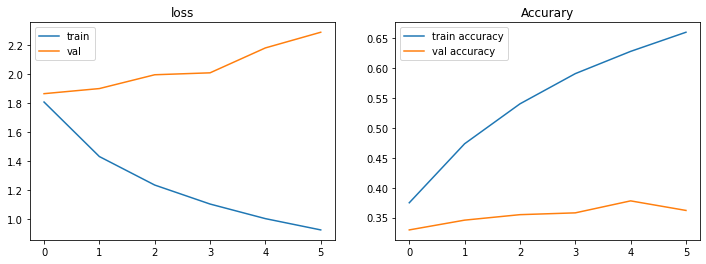

In [28]:
plot_history(history_st)

### Baseline Model

#### Baseline Model Application

Differences to stupid mode: padding, more kernels, extra layer, more filters, with strides, with pooling

In [29]:
### 1. Architecture
model_bl = models.Sequential()

model_bl.add(layers.Conv2D(filters = 16, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same', input_shape=(48, 48, 1)))
model_bl.add(layers.MaxPool2D(pool_size=(3,3))) 

model_bl.add(layers.Conv2D(32, kernel_size=(2,2), activation='relu')) 
model_bl.add(layers.MaxPool2D(pool_size=(2,2))) 

model_bl.add(layers.Conv2D(32, kernel_size=(2,2), activation='relu')) 
model_bl.add(layers.MaxPool2D(pool_size=(2,2))) 

model_bl.add(layers.Flatten())
model_bl.add(layers.Dense(7, activation='softmax')) 

model_bl.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 3, 3, 32)          4128      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 32)        

In [30]:
#### 2. Compilation
model_bl.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [36]:
#### 3. Fit
es = EarlyStopping(patience=20)

history_bl = model_bl.fit(X_train, y_cat_train,
                    epochs=200,
                    batch_size=32, 
                    verbose=1,
                    validation_split=0.3,
                    callbacks=[es]) 

Epoch 1/200
628/628 [==============================] - 10s 16ms/step - loss: 1.6404 - accuracy: 0.3503 - val_loss: 1.6461 - val_accuracy: 0.3485
Epoch 2/200
628/628 [==============================] - 10s 16ms/step - loss: 1.6239 - accuracy: 0.3550 - val_loss: 1.6725 - val_accuracy: 0.3471
Epoch 3/200
628/628 [==============================] - 10s 16ms/step - loss: 1.5990 - accuracy: 0.3717 - val_loss: 1.6413 - val_accuracy: 0.3550
Epoch 4/200
628/628 [==============================] - 10s 16ms/step - loss: 1.5804 - accuracy: 0.3788 - val_loss: 1.6268 - val_accuracy: 0.3706
Epoch 5/200
628/628 [==============================] - 13s 21ms/step - loss: 1.5689 - accuracy: 0.3855 - val_loss: 1.6339 - val_accuracy: 0.3750
Epoch 6/200
628/628 [==============================] - 12s 18ms/step - loss: 1.5547 - accuracy: 0.3923 - val_loss: 1.5995 - val_accuracy: 0.3819
Epoch 7/200
628/628 [==============================] - 11s 17ms/step - loss: 1.5349 - accuracy: 0.4008 - val_loss: 1.6149 - val_ac

#### Baseline Model Evaluation

In [37]:
np.array(history_bl.history["val_accuracy"])

array([0.3485429 , 0.34714967, 0.35504469, 0.37060258, 0.37501451,
       0.38186464, 0.37942645, 0.38697317, 0.38499942, 0.38929525,
       0.38279346, 0.38488331, 0.38662487, 0.39034018, 0.37338907,
       0.39846742, 0.37838152, 0.39869964, 0.39614537, 0.39684197,
       0.37431788, 0.39777082, 0.38813421, 0.38999188, 0.3975386 ,
       0.40171832, 0.39858353, 0.39219785, 0.40090561, 0.38081968,
       0.39660978, 0.39080459, 0.38790202, 0.40020898, 0.39103681,
       0.39591315])

In [38]:
# Evaluate model on the test data
print(model_bl.evaluate(X_test, y_cat_test, verbose=0))

[1.698864459991455, 0.3934243619441986]


(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accurary'}>)

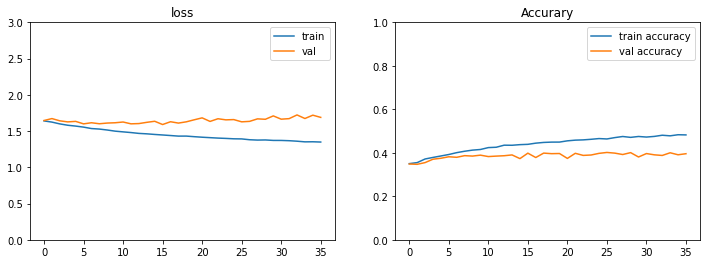

In [41]:
plot_history(history_bl)